Quantum Math Challenge 1 – Grover Search: Find the Secret Number

Idea

We hide a secret number
s $$ \in \{0, 1, \dots, 2^n - 1\}$$ ,
and the only question we are allowed to ask is:

“Is x equal to the secret number?”

This is an example of an unstructured search problem.
- Classical linear search requires
$$O(N) = O(2^n)$$
checks in the worst case, since it may test every candidate.
- Grover’s quantum search finds the marked element using only
$$O(\sqrt{N})$$
oracle calls — a provable quadratic speedup over all classical strategies.

⸻

In this notebook we:
1.	Choose a secret n-bit number.
2.	Run a classical linear search, measuring:
- number of steps (checks),
- total runtime.
3.	Build and run a Grover search circuit:
- on a local Aer simulator,
- and optionally on a real IBM Quantum backend using SamplerV2.
4.	Compare:
- classical vs quantum runtime,
- classical step count (N) vs Grover’s step count $$(\sqrt{N})$$,
- success probability (simulator vs real hardware).

⸻

Theory (Why Grover Is Faster)

Grover’s algorithm performs amplitude amplification:
	1.	Start in a uniform superposition over all $$N = 2^n$$ states
	2.	The oracle flips the phase of the correct state $$|s\rangle$$
	3.	The diffusion operator reflects amplitudes around their average
	4.	Each iteration rotates the state vector toward $$|s\rangle$$ by angle:
      $$
      theta = 2\arcsin(1/\sqrt{N})
      $$
	5.	After
   $$
   k \approx \left\lfloor \frac{\pi}{4}\sqrt{N} \right\rfloor
   $$
   iterations, the measurement probability of $$|s\rangle$$ becomes maximal.

This is provably optimal: no quantum or classical algorithm can solve this problem with fewer than \Theta(\sqrt{N}) queries.

⸻

Conclusions
- Grover search reduces the number of required steps from
$$
O(N) \rightarrow O(\sqrt{N})
$$,
giving a quadratic quantum advantage.
- On the simulator, Grover achieves very high success probability (≈95%).
- On real IBM hardware, success probability is lower (≈40–50%) due to noise, decoherence, and circuit depth — but the algorithmic scaling remains valid.
- The wall-clock time on hardware is longer due to:
- queueing,
- transpilation,
- routing,
- measurement overhead.
This does not change the underlying theoretical advantage.
- Grover’s algorithm remains one of the best demonstrations of true quantum speedup in principle, even if today’s hardware is not yet fast enough to outperform classical CPUs in practice.

In [1]:
%matplotlib inline

import time
import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    SamplerV2 as Sampler,
    EstimatorV2 as Estimator,
)

IBM helpers

In [ ]:
def get_runtime_service(user_token: str = None) -> QiskitRuntimeService:
    """Initialize IBM Quantum Runtime service."""
    token = user_token
    if not token:
        raise ValueError("IBM Quantum API token not provided.")
    QiskitRuntimeService.save_account(
        token=token,
        channel="ibm_cloud",
        overwrite=True,
    )
    service = QiskitRuntimeService(channel="ibm_cloud")
    print("Connected to IBM Quantum service.")
    return service


def get_backend(prefer_ibm: bool = True, min_qubits: int = 1):
    """
    Try to get a real IBM backend; if that fails, return a local AerSimulator.
    """
    if prefer_ibm:
        try:
            user_token = "YOUR_IBM_QUANTUM_API_TOKEN"
            service = get_runtime_service(user_token)
            backend = service.least_busy(
                operational=True,
                simulator=False,
                min_num_qubits=min_qubits,
            )
            print(f"Using IBM backend: {backend.name}")
            return backend, "ibm"
        except Exception as e:
            print("Could not connect to IBM runtime, falling back to AerSimulator.")
            print("Reason:", e)

    backend = AerSimulator()
    print("Using local AerSimulator backend.")
    return backend, "aer"

Classical linear search

In [3]:
def classical_linear_search(secret: int, n_bits: int):
    """
    Naive linear search 0..2^n-1.
    Returns (actual_steps, elapsed_time_seconds).
    """
    N = 2**n_bits
    start = time.perf_counter()
    steps = 0
    for x in range(N):
        steps += 1
        if x == secret:
            break
    elapsed = time.perf_counter() - start
    return steps, elapsed

Grover building blocks

In [4]:
def secret_to_bitstring(x: int, n: int) -> str:
    return format(x, f"0{n}b")


def grover_iterations(n: int) -> int:
    """
    Theoretically optimal number of Grover iterations:
      R ≈ pi/4 * sqrt(N), N = 2^n.
    """
    N = 2**n
    return int(np.floor(np.pi / 4 * math.sqrt(N)))


def build_oracle(secret: int, n: int) -> QuantumCircuit:
    """
    Phase oracle for Grover:
      |x> -> -|x> if x == secret, else |x>.
    """
    secret_bits = secret_to_bitstring(secret, n)
    qc = QuantumCircuit(n, name="Oracle")

    # Map |secret> to |11..1> using X gates
    for q, bit in enumerate(reversed(secret_bits)):  # q0 is LSB
        if bit == "0":
            qc.x(q)

    # Multi-controlled Z via H–MCX–H on last qubit
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)
    qc.h(n - 1)

    # Undo X
    for q, bit in enumerate(reversed(secret_bits)):
        if bit == "0":
            qc.x(q)

    return qc


def build_diffuser(n: int) -> QuantumCircuit:
    """
    Grover diffuser: reflection about the uniform superposition state.
    """
    qc = QuantumCircuit(n, name="Diffuser")
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)
    qc.h(n - 1)
    qc.x(range(n))
    qc.h(range(n))
    return qc


def build_grover_circuit(n: int, secret: int) -> QuantumCircuit:
    """
    Full Grover circuit:
      - start in |0^n>
      - apply H to all qubits
      - perform R Grover iterations
      - measure all qubits
    """
    iterations = grover_iterations(n)
    oracle = build_oracle(secret, n)
    diffuser = build_diffuser(n)

    qc = QuantumCircuit(n)
    qc.h(range(n))

    for _ in range(iterations):
        qc.append(oracle, range(n))
        qc.append(diffuser, range(n))

    qc.measure_all()
    return qc

Run Grover on sim / IBM

In [5]:
def run_grover_quantum(n: int, secret: int, shots: int = 2048, use_ibm: bool = False):
    """
    Runs the Grover circuit on either local simulator or IBM backend.
    Returns (backend_kind, counts_dict, elapsed_time_seconds).
    """
    backend, kind = get_backend(prefer_ibm=use_ibm, min_qubits=n)
    qc = build_grover_circuit(n, secret)

    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_qc = pm.run(qc)

    start = time.perf_counter()
    if kind == "aer":
        job = backend.run(isa_qc, shots=shots)
        result = job.result()
        counts = result.get_counts()
    else:
        sampler = Sampler(mode=backend)
        sampler.options.default_shots = shots
        job = sampler.run([isa_qc], shots=shots)
        pub = job.result()[0]
        counts = pub.join_data().get_counts()
    elapsed = time.perf_counter() - start

    return kind, counts, elapsed

Interactive scenario

In [ ]:
def grover_interactive():
    print("=== Grover Search Challenge ===")

    # Input n
    n_str = input("Enter number of qubits n (e.g., 3 or 4): ").strip()
    try:
        n = int(n_str)
        if n <= 0 or n > 10:
            raise ValueError
    except ValueError:
        print("Invalid n, using n = 3.")
        n = 3

    shots_str = input("Enter number of shots (default 2048): ").strip()
    try:
        shots = int(shots_str) if shots_str else 2048
    except ValueError:
        shots = 2048

    # IBM
    use_ibm_str = input("Also run on IBM Quantum? (y/n): ").strip().lower()
    use_ibm = use_ibm_str == "y"
    secret = np.random.randint(0, 2**n)
    secret_str = secret_to_bitstring(secret, n)
    print(f"\nSecret number: {secret} (bitstring {secret_str})")

    N = 2**n
    grover_iters = grover_iterations(n)

    # Classical search
    print("\n[Classical linear search]...")
    steps_classical, t_classical = classical_linear_search(secret, n)
    print(f"  Theoretical worst case: O(N) = {N} checks")
    print(f"  Actual steps until found: {steps_classical}")
    print(f"  Time: {t_classical:.6f} s")

    # Simulator
    print("\n[Grover on Aer simulator]...")
    kind_sim, counts_sim, t_sim = run_grover_quantum(
        n=n, secret=secret, shots=shots, use_ibm=False
    )
    p_success_sim = counts_sim.get(secret_str, 0) / shots
    print(f"  Grover iterations: {grover_iters}")
    print(f"  Success probability (sim): {p_success_sim:.3f}")
    print(f"  Time (sim): {t_sim:.6f} s")
    plot_histogram(counts_sim, title="Grover — simulator")

    # Quantum on IBM
    t_ibm = None
    p_success_ibm = None
    if use_ibm:
        print("\n[Grover on IBM Quantum backend]...")
        kind_ibm, counts_ibm, t_ibm = run_grover_quantum(
            n=n, secret=secret, shots=shots, use_ibm=True
        )
        p_success_ibm = counts_ibm.get(secret_str, 0) / shots
        print(f"  Grover iterations: {grover_iters}")
        print(f"  Success probability (IBM): {p_success_ibm:.3f}")
        print(f"  Time (IBM): {t_ibm:.6f} s")
        plot_histogram(counts_ibm, title="Grover — IBM backend")

    labels_time = ["Classical", "Quantum sim"]
    values_time = [t_classical, t_sim]
    if t_ibm is not None:
        labels_time.append("Quantum IBM")
        values_time.append(t_ibm)

    plt.figure()
    plt.bar(labels_time, values_time)
    plt.ylabel("Time (seconds)")
    plt.title("Runtime: classical vs quantum")
    plt.show()

    classical_steps_theoretical = N
    quantum_steps_theoretical = grover_iters

    plt.figure()
    plt.bar(
        ["Classical (N checks)", "Grover (≈π/4·√N iterations)"],
        [classical_steps_theoretical, quantum_steps_theoretical],
    )
    plt.ylabel("Number of oracle calls / steps")
    plt.title("Steps: classical search vs Grover's algorithm")
    plt.show()

    print("\n=== Summary ===")
    print(f"Classical: time = {t_classical:.6f} s, steps ≈ {N}, actual {steps_classical}")
    print(f"Grover:   iterations ≈ {grover_iters}, measurements = {shots}")
    print(f"Sim:      time = {t_sim:.6f} s, p_success = {p_success_sim:.3f}")
    if t_ibm is not None:
        print(f"IBM:      time = {t_ibm:.6f} s, p_success = {p_success_ibm:.3f}")

=== Grover Search Challenge ===

Secret number: 9 (bitstring 1001)

[Classical linear search]...
  Theoretical worst case: O(N) = 16 checks
  Actual steps until found: 10
  Time: 0.000002 s

[Grover on Aer simulator]...
Using local AerSimulator backend.
  Grover iterations: 3
  Success probability (sim): 0.957
  Time (sim): 0.002779 s

[Grover on IBM Quantum backend]...


qiskit_runtime_service.__init__:WARNING:2025-11-14 11:54:50,448: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: new_instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().


Connected to IBM Quantum service.


qiskit_runtime_service.backends:WARNING:2025-11-14 11:54:50,880: Loading instance: new_instance, plan: open
qiskit_runtime_service.backends:WARNING:2025-11-14 11:54:52,704: Using instance: new_instance, plan: open


Using IBM backend: ibm_fez
  Grover iterations: 3
  Success probability (IBM): 0.464
  Time (IBM): 5.954248 s


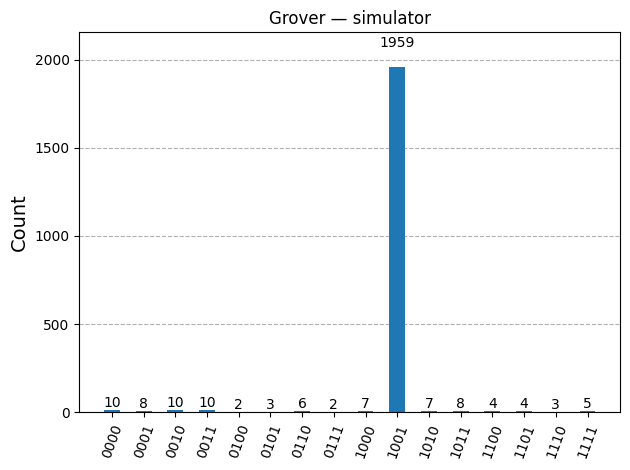

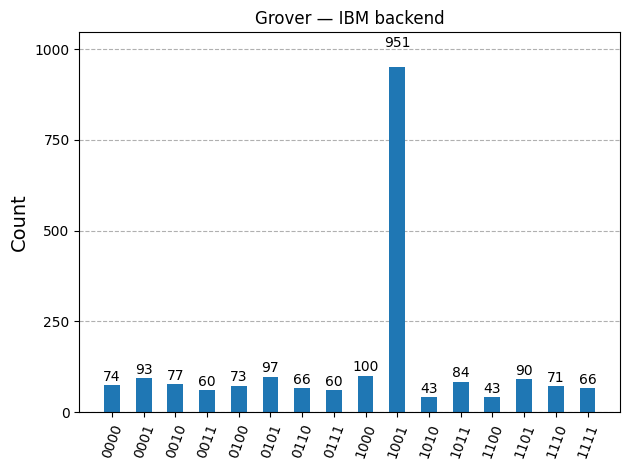

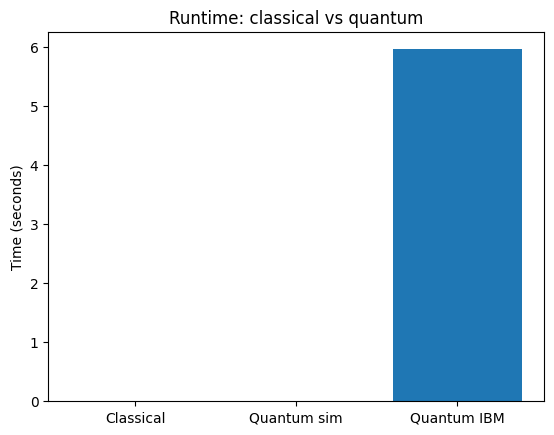

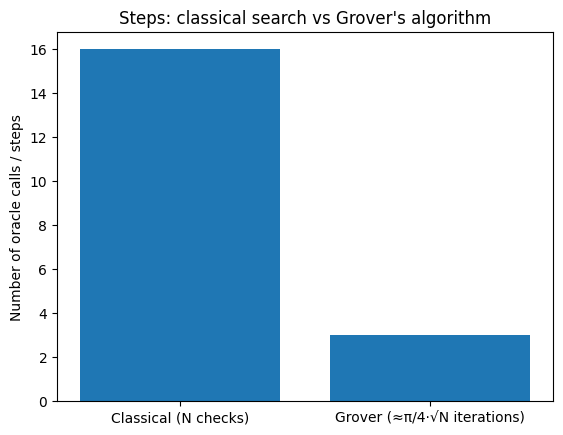


=== Summary ===
Classical: time = 0.000002 s, steps ≈ 16, actual 10
Grover:   iterations ≈ 3, measurements = 2048
Sim:      time = 0.002779 s, p_success = 0.957
IBM:      time = 5.954248 s, p_success = 0.464


In [7]:
grover_interactive()